# Performance Prediction

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import perf_predict as pp
from layer import BaseLayer, ConvLayer, STD, DPT, PNT, MatmulLayer
from net import VGG16, RESNET50, MOBILENET_V1, MOBILENET_V2, VGG16_OPT
from design import BasicDesign, DesignParams
from explorer import BasicExplorer
from fpga_platform import StratixVPlatform

## VGG-16

In [3]:
VGG16

             conv1_1: <224, 224,    3,   64, 3,   standard>   0.170326   0.001728
             conv1_2: <224, 224,   64,   64, 3,   standard>   3.633611   0.036864
             conv2_1: <112, 112,   64,  128, 3,   standard>   1.784218   0.073728
             conv2_2: <112, 112,  128,  128, 3,   standard>   3.568435   0.147456
             conv3_1: < 56,  56,  128,  256, 3,   standard>   1.719927   0.294912
             conv3_2: < 56,  56,  256,  256, 3,   standard>   3.439854   0.589824
             conv3_3: < 56,  56,  256,  256, 3,   standard>   3.439854   0.589824
             conv4_1: < 28,  28,  256,  512, 3,   standard>   1.594884   1.179648
             conv4_2: < 28,  28,  512,  512, 3,   standard>   3.189768   2.359296
             conv4_3: < 28,  28,  512,  512, 3,   standard>   3.189768   2.359296
             conv5_1: < 14,  14,  512,  512, 3,   standard>   0.679477   2.359296
             conv5_2: < 14,  14,  512,  512, 3,   standard>   0.679477   2.359296
             con

In [4]:
VGG16.num_params * 1e-6

138.34412799999998

In [5]:
VGG16.num_ops * 1e-9

28.016342528000003

In [6]:
design = BasicDesign(DesignParams())
predictor = pp.BasicPredictor()
predictor.predict(VGG16, design)

(1828814848, 9.14407424, 3.063879600347602, 19127894016, 0.7323425805414082)

In [7]:
%%time

explorer = BasicExplorer()
platform = StratixVPlatform()
VGG16_explore = explorer.explore(VGG16, platform, use_winograd=True)

CPU times: user 19.2 s, sys: 23 ms, total: 19.3 s
Wall time: 19.2 s


In [8]:
sr = sorted(VGG16_explore, key=lambda x: x[5], reverse=True)
sr[0]

array([6, 2304, 52000, 7447520, 0.0372376, 752.3670303134467,
       23.055131927989024, <design.DesignParams object at 0x7fde9b5f6f98>],
      dtype=object)

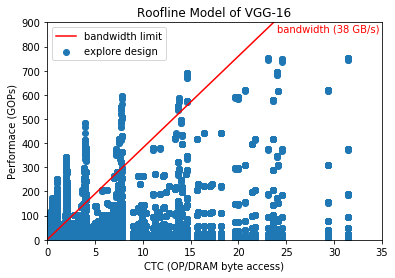

In [9]:
max_GFLOPS = 2 * platform.max_DSP / (1. / (200 * 1e6)) * 1e-9

fig, ax = plt.subplots()

xs = VGG16_explore[:,6]
ys = VGG16_explore[:,5]

bxs = np.arange(30)
bys = bxs * 38
cxs = np.arange(40)
cys = 40 * [max_GFLOPS]

ax.text(24, 860, r'bandwidth (38 GB/s)', color='red')
ax.scatter(xs, ys, label='explore design')
ax.plot(bxs, bys, 'r', label='bandwidth limit')
ax.plot(cxs, cys)

ax.set_title('Roofline Model of VGG-16')
ax.set_xlabel('CTC (OP/DRAM byte access)')
ax.set_ylabel('Performace (GOPs)')
ax.set_xlim([0, 35])
ax.set_ylim([0, 900])
ax.legend()

fig.savefig('vgg16_roofline.pdf')

## ResNet-50

In [10]:
RESNET50

       conv2_1/conv1: < 56,  56,   64,   64, 1,  pointwise>   0.025690   0.004096
       conv2_1/conv2: < 56,  56,   64,   64, 3,   standard>   0.231211   0.036864
       conv2_1/conv3: < 56,  56,   64,  256, 1,  pointwise>   0.102760   0.016384
       conv2_2/conv1: < 56,  56,  256,   64, 1,  pointwise>   0.102760   0.016384
       conv2_2/conv2: < 56,  56,   64,   64, 3,   standard>   0.231211   0.036864
       conv2_2/conv3: < 56,  56,   64,  256, 1,  pointwise>   0.102760   0.016384
       conv2_3/conv1: < 56,  56,  256,   64, 1,  pointwise>   0.102760   0.016384
       conv2_3/conv2: < 56,  56,   64,   64, 3,   standard>   0.231211   0.036864
       conv2_3/conv3: < 56,  56,   64,  256, 1,  pointwise>   0.102760   0.016384
       conv3_1/conv1: < 56,  56,  256,  128, 1,  pointwise>   0.051380   0.032768
       conv3_1/conv2: < 28,  28,  128,  128, 3,   standard>   0.231211   0.147456
       conv3_1/conv3: < 28,  28,  128,  512, 1,  pointwise>   0.102760   0.065536
       conv3_2/c

In [11]:
RESNET50.num_ops * 1e-9

6.760595456000001

In [56]:
RESNET50.num_params * 1e-6

22.724608

In [13]:
design = BasicDesign(DesignParams())
predictor = pp.BasicPredictor()
predictor.predict(RESNET50, design)

(1967341568, 9.83670784, 0.6872823271733971, 7546191872, 0.4479474926343352)

In [14]:
%%time

explorer = BasicExplorer()
platform = StratixVPlatform()
RESNET50_explore = explorer.explore(RESNET50, platform, use_winograd=True)

CPU times: user 47.5 s, sys: 54.8 ms, total: 47.6 s
Wall time: 47.6 s


In [15]:
sr = sorted(RESNET50_explore, key=lambda x: x[5], reverse=True)
sr[0]

array([6, 2304, 52000, 2066112, 0.01033056, 654.4268128736487,
       23.871684359723467, <design.DesignParams object at 0x7fde99cf9e80>],
      dtype=object)

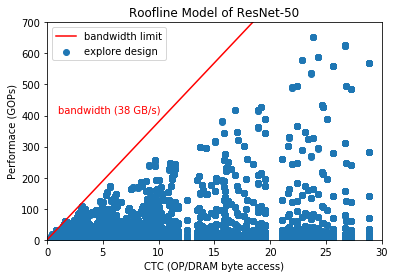

In [16]:
max_GFLOPS = 2 * platform.max_DSP / (1. / (200 * 1e6)) * 1e-9

fig, ax = plt.subplots()

xs = RESNET50_explore[:,6]
ys = RESNET50_explore[:,5]

bxs = np.arange(30)
bys = bxs * 38
cxs = np.arange(40)
cys = 40 * [400]

ax.text(1, 410, r'bandwidth (38 GB/s)', color='red')
ax.scatter(xs, ys, label='explore design')
ax.plot(bxs, bys, 'r', label='bandwidth limit')

ax.set_title('Roofline Model of ResNet-50')
ax.set_xlabel('CTC (OP/DRAM byte access)')
ax.set_ylabel('Performace (GOPs)')
ax.set_xlim([0, 30])
ax.set_ylim([0, 700])
ax.legend()

fig.savefig('resnet50_roofline.pdf')

## MobileNet V1

In [17]:
MOBILENET_V1

               conv0: <224, 224,    3,   32, 3,   standard>   0.021870   0.000864
     conv1/depthwise: <112, 112,   32,   32, 3,  depthwise>   0.007225   0.000288
     conv1/pointwise: <112, 112,   32,   64, 1,  pointwise>   0.051380   0.002048
     conv2/depthwise: <112, 112,   64,   64, 3,  depthwise>   0.003677   0.000576
     conv2/pointwise: < 56,  56,   64,  128, 1,  pointwise>   0.051380   0.008192
     conv3/depthwise: < 56,  56,  128,  128, 3,  depthwise>   0.007225   0.001152
     conv3/pointwise: < 56,  56,  128,  128, 1,  pointwise>   0.102760   0.016384
     conv4/depthwise: < 56,  56,  128,  128, 3,  depthwise>   0.001871   0.001152
     conv4/pointwise: < 28,  28,  128,  256, 1,  pointwise>   0.051380   0.032768
     conv5/depthwise: < 28,  28,  256,  256, 3,  depthwise>   0.003613   0.002304
     conv5/pointwise: < 28,  28,  256,  256, 1,  pointwise>   0.102760   0.065536
     conv6/depthwise: < 28,  28,  256,  256, 3,  depthwise>   0.000969   0.002304
     conv6/point

In [57]:
MOBILENET_V1.num_ops * 1e-9 / 2, MOBILENET_V1.num_params * 1e-6

(0.5689685200000001, 4.2090879999999995)

In [19]:
design = BasicDesign(DesignParams())
predictor = pp.BasicPredictor()
predictor.predict(MOBILENET_V1, design)

(548393984, 2.74196992, 0.41500712013646024, 1708203008, 0.33308015343337927)

In [20]:
%%time

explorer = BasicExplorer()
platform = StratixVPlatform()
MOBILENET_V1_explore = explorer.explore(MOBILENET_V1, platform, use_winograd=True)

CPU times: user 29 s, sys: 19.9 ms, total: 29 s
Wall time: 29 s


In [21]:
sr = sorted(MOBILENET_V1_explore, key=lambda x: x[5], reverse=True)
sr[0]

array([9, 2304, 164000, 1244496, 0.00622248, 182.87516231470414,
       8.647989421206226, <design.DesignParams object at 0x7fde9a8e8128>],
      dtype=object)

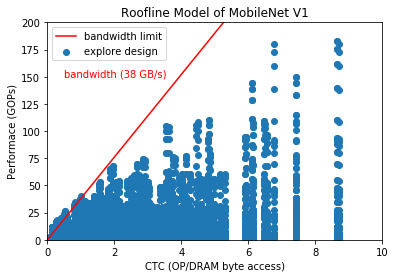

In [22]:
max_GFLOPS = 2 * platform.max_DSP / (1. / (200 * 1e6)) * 1e-9

fig, ax = plt.subplots()

xs = MOBILENET_V1_explore[:,6]
ys = MOBILENET_V1_explore[:,5]

bxs = np.arange(30)
bys = bxs * 38
cxs = np.arange(40)
cys = 40 * [400]

ax.text(0.5, 150, r'bandwidth (38 GB/s)', color='red')
ax.scatter(xs, ys, label='explore design')
ax.plot(bxs, bys, 'r', label='bandwidth limit')
# ax.plot(cxs, cys, 'r--', label='computation limit')

ax.set_title('Roofline Model of MobileNet V1')
ax.set_xlabel('CTC (OP/DRAM byte access)')
ax.set_ylabel('Performace (GOPs)')
ax.set_xlim([0, 10])
ax.set_ylim([0, 200])
ax.legend()

fig.savefig('mobilenet_v1_roofline.pdf')

## MobileNet V2

In [23]:
MOBILENET_V2

               conv0: <224, 224,    3,   32, 3,   standard>   0.021870   0.000864
   expand_conv/conv1: <112, 112,   32,   32, 1,  pointwise>   0.025690   0.001024
   expand_conv/conv2: <112, 112,   32,   32, 3,  depthwise>   0.007225   0.000288
   expand_conv/conv3: <112, 112,   32,   16, 1,  pointwise>   0.012845   0.000512
 expand_conv_1/conv1: <112, 112,   16,   96, 1,  pointwise>   0.038535   0.001536
 expand_conv_1/conv2: <112, 112,   96,   96, 3,  depthwise>   0.005516   0.000864
 expand_conv_1/conv3: < 56,  56,   96,   24, 1,  pointwise>   0.014451   0.002304
 expand_conv_2/conv1: < 56,  56,   24,   96, 1,  pointwise>   0.014451   0.002304
 expand_conv_2/conv2: < 56,  56,   96,   96, 3,  depthwise>   0.005419   0.000864
 expand_conv_2/conv3: < 56,  56,   96,   24, 1,  pointwise>   0.014451   0.002304
 expand_conv_3/conv1: < 56,  56,   24,  144, 1,  pointwise>   0.021676   0.003456
 expand_conv_3/conv2: < 56,  56,  144,  144, 3,  depthwise>   0.002105   0.001296
 expand_conv_3/c

In [60]:
MOBILENET_V2.num_ops * 1e-9, MOBILENET_V2.num_params * 1e-6

(0.610567272, 3.468048)

In [25]:
design = BasicDesign(DesignParams())
predictor = pp.BasicPredictor()
predictor.predict(MOBILENET_V1, design)

(548393984, 2.74196992, 0.41500712013646024, 1708203008, 0.33308015343337927)

In [26]:
%%time

explorer = BasicExplorer()
platform = StratixVPlatform()
MOBILENET_V2_explore = explorer.explore(MOBILENET_V2, platform, use_winograd=True)

CPU times: user 51.3 s, sys: 59.4 ms, total: 51.4 s
Wall time: 51.4 s


In [27]:
sr = sorted(MOBILENET_V2_explore, key=lambda x: x[5], reverse=True)
sr[0]

array([9, 2304, 164000, 1280690, 0.00640345, 95.34973678251569,
       4.2896232932763425, <design.DesignParams object at 0x7fde96bd1630>],
      dtype=object)

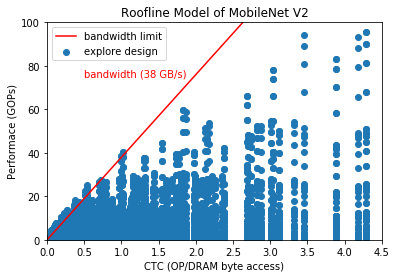

In [28]:
max_GFLOPS = 2 * platform.max_DSP / (1. / (200 * 1e6)) * 1e-9

fig, ax = plt.subplots()

xs = MOBILENET_V2_explore[:,6]
ys = MOBILENET_V2_explore[:,5]

bxs = np.arange(30)
bys = bxs * 38
cxs = np.arange(40)
cys = 40 * [400]

ax.text(0.5, 75, r'bandwidth (38 GB/s)', color='red')
ax.scatter(xs, ys, label='explore design')
ax.plot(bxs, bys, 'r', label='bandwidth limit')
# ax.plot(cxs, cys, 'r--', label='computation limit')

ax.set_title('Roofline Model of MobileNet V2')
ax.set_xlabel('CTC (OP/DRAM byte access)')
ax.set_ylabel('Performace (GOPs)')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 100])
ax.legend()

fig.savefig('mobilenet_v2_roofline.pdf')

### Optimised VGG-16

In [61]:
VGG16_OPT

             conv1_1: <224, 224,    3,   64, 3,   standard>   0.170326   0.001728
             conv1_2: <224, 224,   64,   64, 3,   standard>   3.633611   0.036864
             conv2_1: <112, 112,   64,  128, 3,   standard>   1.784218   0.073728
             conv2_2: <112, 112,  128,  128, 3,   standard>   3.568435   0.147456
             conv3_1: < 56,  56,  128,  256, 3,   standard>   1.719927   0.294912
             conv3_2: < 56,  56,  256,  256, 3,   standard>   3.439854   0.589824
             conv3_3: < 56,  56,  256,  256, 3,   standard>   3.439854   0.589824
             conv4_1: < 28,  28,  256,  512, 3,   standard>   1.594884   1.179648
             conv4_2: < 28,  28,  512,  512, 3,   standard>   3.189768   2.359296
             conv4_3: < 28,  28,  512,  512, 3,   standard>   3.189768   2.359296
   conv5_1/depthwise: < 14,  14,  512,  512, 3,  depthwise>
   conv5_1/pointwise: < 14,  14,  512,  512, 1,  pointwise>   0.104567   0.266752
   conv5_2/depthwise: < 14,  14,  512,

In [62]:
VGG16_OPT.num_ops * 1e-9, VGG16_OPT.num_params * 1e-6

(26.291611136, 132.066496)

In [63]:
%%time
explorer = BasicExplorer()
platform = StratixVPlatform()
VGG16_OPT_explore = explorer.explore(VGG16_OPT, platform, use_winograd=True)

RuntimeError: Type of layer conv5_1 is not supported: <class 'layer.DepthwiseSeparableBlock'>

## Summary

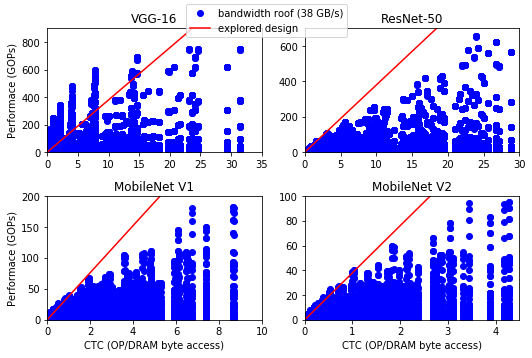

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7.5, 5))

results = [
    VGG16_explore,
    RESNET50_explore,
    MOBILENET_V1_explore,
    MOBILENET_V2_explore,
]

bxlim = [30, 30, 30, 30]
xlim = [35, 30, 10, 4.5]
ylim = [900, 700, 200, 100]
text_pos = [(24, 860), (1, 410), (0.5, 150), (0.5, 75)]
names = ['VGG-16', 'ResNet-50', 'MobileNet V1', 'MobileNet V2']

for idx, result in enumerate(results):
    i, j = int(idx / 2), idx % 2
    xs = result[:,6]
    ys = result[:,5]

    bxs = np.arange(xlim[idx])
    bys = bxs * 38

    # ax[i,j].text(text_pos[idx][0], text_pos[idx][1], r'bandwidth (38 GB/s)', color='red')
    ax[i,j].plot(xs, ys, 'o', color='b', label='explore design', rasterized=True)
    ax[i,j].plot(bxs, bys, 'r', label='bandwidth roof')
    # ax[i,j].plot(cxs, cys)

    ax[i,j].set_title(names[idx])
    if i == 1:
        ax[i,j].set_xlabel('CTC (OP/DRAM byte access)')
    if j == 0:
        ax[i,j].set_ylabel('Performace (GOPs)')
    ax[i,j].set_xlim([0, xlim[idx]])
    ax[i,j].set_ylim([0, ylim[idx]])
    

fig.tight_layout()
plt.figlegend(['bandwidth roof (38 GB/s)', 'explored design'], loc='upper center')
fig.savefig('roofline_summary.pdf')